<h1>DESAFIO TÉCNICO - CIENTISTA DE DADOS JÚNIOR - AMERICANAS S.A.</h1>

<h2>PARTE 2 - PREPARAÇÃO, CONSTRUÇÃO E AVALIAÇÃO DO MODELO</h2>

---

<h2>SUMÁRIO</h2>

* TRATAMENTO DE OUTLIERS BASEADO EM ESTATÍSTICA
    * Z-Score
    * Amplitude Interquartil
    <br/>
    <br/>

* MÉTODOS DE DETECÇÃO DE OUTLIERS MULTIVARIADOS
* MÉTODOS DE DETECÇÃO BASEADO EM CLUSTERS
* FEATURE SELECTION
* DIVISÃO EM TREINO E TESTE
* ESCALA DOS DADOS
* MODELAGEM BASE
    * K Fold
    * KNN
    * Logistic Regression
    * Random Forest
    * SVM Classifier
    * XGB Classifier<br/><br/>
* MODELAGEM AUTOMATIZADA
    * Avaliando os resultados<br/><br/>
* EXPORTANDO O MODELO
* CONSIDERAÇÕES SOBRE OS RESULTADOS OBTIDOS

---

### Importações dos pacotes que serão utilizados

In [1]:
#Pacotes para manipulação de dados e arrays em Python
import pandas as pd
import numpy as np

#Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

import sklearn.cluster as cluster
from tqdm import tqdm
from sklearn.metrics import silhouette_score

import re

# Bibliotecas para computação estatística
from scipy import stats

In [3]:
df = pd.read_csv('data/dataset.csv')
df_transformed = df.copy()

---

<h2>TRATAMENTO DE OUTLIERS BASEADO EM ESTATÍSTICA</h2>

<h3>Z-Score</h3>

A primeira etapa do processo de tratamento será encontrar os registros cujo desvio-padrão é maior que 3. Para isso, irei criar uma função que recebe o dataframe e a coluna alvo e retorna um array de índices contendo os outliers.

In [4]:
def testeZScore(df, coluna, threshold = 3):
    #Cálculo do Z-score
    z = np.abs(stats.zscore(df[coluna]))

    #Selecionando somente os valores acima do threshold
    indices = list(np.array(np.where(z > threshold)).reshape(-1))

    #Visualizando os outliers
    df_res = df.iloc[indices]

    return df_res, indices

Aqui irei percorrer todas as colunas do dataset e aplicar a função que testa a pontuação de Z-score. Em seguida, irei adicionar todos os índices em uma lista de índices.

O objetivo desta etapa é observar quais dados são outliers em mais de uma coluna do dataset.

In [5]:
lista_indices_outliers = []
for column in df_transformed:
    df_zscore, indices = testeZScore(df_transformed, column, threshold=3)
    lista_indices_outliers.extend(indices)

In [6]:
sr_outlier = pd.Series(lista_indices_outliers).value_counts()
sr_outlier = sr_outlier.loc[sr_outlier.values > 3]
sr_outlier

127    7
429    6
418    5
dtype: int64

Os registros que são outliers em mais do que três colunas serão removidos do dataset.

In [7]:
df_transformed.drop(index=sr_outlier.index, inplace=True)
df_transformed.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,target
0,200.0,2,662.28,39.10,-188.55,0.246978,761,0.004548,3.523703,167326,33441.06,0.019804,26.850,0.009198,94.611429,7,0
1,150.0,2,0.00,149.55,-0.45,0.150000,3,0.037975,0.000000,79,78.93,0.000000,0.000,0.000000,0.000000,0,1
2,50.0,1,346.08,30.41,-102.10,2.430952,42,0.004239,3.389618,9907,18858.77,0.018351,25.525,0.095238,86.520000,4,0
3,100.0,2,0.00,43.84,-56.16,0.150968,372,0.005854,0.000000,63544,1164.11,0.000000,0.000,0.000000,0.000000,0,1
4,50.0,1,87.56,-3.05,-94.50,0.412664,229,0.004572,0.926561,50089,1786.26,0.049019,94.500,0.004367,87.560000,1,0


<h3>Amplitude Interquartil</h3>

Agora irei aplicar o teste de amplitude interquartil para obter os dados outliers. A diferença dessa fórmula para o z-score é que a distância interquartil obtém o equivalente a 2.69 desvios-padrão do centro. É uma diferença sútil, mas que possibilita uma quantidade maior de outliers.

> **Nota:**<br/> 
> **3** Desvios-padrão equivale a cerca de **99.7%** dos dados;<br/> 
> **2.69** Desvios-padrão equivalem a cerca de **99.3%** dos dados;<br/> 

In [8]:
#Método que calcula o IQR do atributo. Recebe o dataframe e a coluna-alvo como parâmetros e retorna os limites inferior e superior.
#O limite inferior representa os outliers à esquerda dos dados;
#O limite superior representa os outliers à direita dos dados;

def testeIQR(df, column):
    Q1 = np.percentile(df[column], 25, interpolation='midpoint')
    Q3 = np.percentile(df[column], 75, interpolation='midpoint')
    IQR = Q3 - Q1

    lowerFence = Q1 - 1.5 * IQR
    upperFence = Q3 + 1.5 * IQR

    return lowerFence, upperFence

Para cada coluna no dataset eu irei calcular os limites IQR e obter os outliers. Coms os outliers em mãos, é hora de tratá-los. Para tratar os outliers eu decidi obter a mediana agrupada por atributo target.

Portanto, irei atribuir aos outliers a mediana baseada no grupo target do atributo.

In [9]:
df_corr = df_transformed.corr()

for column in df_transformed:
    lowerFence, upperFence = testeIQR(df_transformed, column)
    if column != 'target':
        df_corr[column] = df_corr[column].apply(lambda x: np.abs(x))
        column_corr = df_corr[column].sort_values(ascending=False).index[1]


        df_transformed.loc[df_transformed[column] > upperFence, column] = df_transformed.groupby(['target'])[column].transform('median')
        df_transformed.loc[df_transformed[column] < lowerFence, column] = df_transformed.groupby(['target'])[column].transform('median')

In [12]:
df.skew()

feature0      9.493694
feature1      2.205723
feature2      6.999722
feature3      4.690919
feature4     -9.749162
feature5      2.582785
feature6      3.601131
feature7     20.903537
feature8     13.371251
feature9      3.757792
feature10     6.910018
feature11    20.349341
feature12     8.667887
feature13     5.414284
feature14     7.948637
feature15    10.315737
target       -0.234086
dtype: float64

In [11]:
df_transformed.skew()

feature0     1.444436
feature1     1.624980
feature2     1.915365
feature3     0.753863
feature4    -1.555334
feature5     1.239984
feature6     1.430369
feature7     1.525780
feature8     1.620020
feature9     1.426708
feature10    1.657428
feature11    1.440402
feature12    1.488444
feature13    1.420099
feature14    0.666211
feature15    1.993003
target      -0.240054
dtype: float64

**Considerações**

Com alguns tratamentos de outliers, nosso Skewness já caiu consideravelmente, irei tentar melhorar ainda mais.

---
<h2>MÉTODOS DE DETECÇÃO DE OUTLIERS MULTIVARIADOS</h2>

A detecção de outliers baseada em ângulo (ABOD) é uma das técnicas populares para detectar anomalias ou outliers em um determinado conjunto de dados e é frequentemente usada na prática ao trabalhar com dados multivariados.

Este método calcula a variância obtida entre três ou mais ângulos. De maneira gelal, a variância é maior para os dados inliers do que para os dados outliers, portanto, o cálculo ajuda a agrupar dados normais e dados outliers de maneira diferente.

Particularmente, esta técnica funciona muito bem em um espaço multivariado de altas dimensões.

**Porém, com o uso desta técnica eu não obtive melhora nos resultados, portanto, decidi por não utilizá-la neste projeto.**

> from pyod.models.abod import ABOD

> abod_clf = ABOD(contamination=0.05) <br/>
> abod_clf.fit(df_transformed)

> #Return the classified inlier/outlier <br/>
> np.where(abod_clf.labels_ == 1)

> df_transformed['ABOD_Clf'] = abod_clf.labels_

> for column in df_transformed: <br/>
>    if column != 'target': <br/>
>        df_transformed.loc[df_transformed['ABOD_Clf'] == 1, column] = df_transformed.groupby(['target'])[column].transform('median') <br/>

> df_transformed.drop(columns=['ABOD_Clf'], inplace=True)

> df_transformed.skew()

<h2>MÉTODOS DE DETECÇÃO BASEADO EM CLUSTERS</h2>

Outra ferramenta que eu decidi utilizar para tratar os outliers, foi dividir os dados em clusters. Detalhando passo a passo eu fiz:
* Fiz uma cópia do dataset original;
* Criei um range de 2 a 11 clusters;
* Após isso, eu obtive o cálculo da Intertia par ter uma noção de mais ou menos quantos clusters ficará bom;
* Além do intertia, eu utilizei o silhoute score para ter mais uma métrica de quantos clusters devo utilizar;
* Com os clusters definido, é hora de treinar o modelo.
* Para substituir os dados eu utilizei um esquema parecido com o método por amplitude interquartil;
    * Obtive os dados além do limite inferior e superior. 
    * Substitui os outliers pela mediana agrupadas por target e por clusters.

In [13]:
df_copy = df_transformed.copy()
df_copy.drop(columns='target', inplace=True)

scaler = RobustScaler()
df_copy = scaler.fit_transform(df_copy)

In [14]:
inertia = []
for i in tqdm(range(2,11)):
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++', n_init=15, max_iter=500, random_state=17)
    kmeans.fit(df_copy)
    inertia.append(kmeans.inertia_)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 11%|█         | 1/9 [00:01<00:10,  1.28s/it]C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 22%|██▏       | 2/9 [00:02<00:08,  1.24s/it]C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment 

In [15]:
silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++', n_init=15, max_iter=500, random_state=17)
    kmeans.fit(df_copy)
    silhouette[i] = silhouette_score(df_copy, kmeans.labels_, metric='euclidean')

  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 12%|█▎        | 1/8 [00:01<00:08,  1.18s/it]C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 25%|██▌       | 2/8 [00:02<00:07,  1.26s/it]C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment 

Text(0.5, 0, 'Número de clusters')

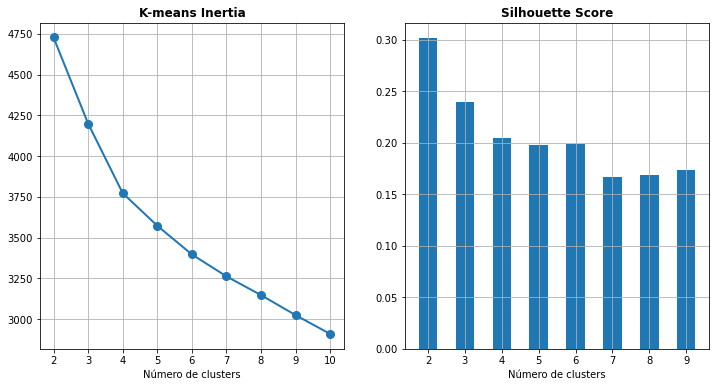

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8)
plt.xlabel('Número de clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Número de clusters')

In [17]:
kmeans = cluster.KMeans(n_clusters=6, init='k-means++', n_init=15, max_iter=1000, random_state=17)
df_transformed['cluster'] = kmeans.fit_predict(df_copy)

C:\Users\krupc\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [18]:
for i in range(1):
    for column in df_transformed:
        lowerFence, upperFence = testeIQR(df_transformed, column)
        if column != 'target':
    
            df_transformed.loc[df_transformed[column] > upperFence, column] = df_transformed.groupby(['target', 'cluster'])[column].transform('median')
            df_transformed.loc[df_transformed[column] < lowerFence, column] = df_transformed.groupby(['target', 'cluster'])[column].transform('median')

In [19]:
df_transformed.drop(columns='cluster', inplace=True)

---

<h2>FEATURE SELECTION</h2>

Quero selecionar os atributos que são mais relevantes para o modelo. Para isso irei utilizar a matriz de correlação para identificar as correlações mais fortes da variável target com as demais variáveis preditoras.

<AxesSubplot:>

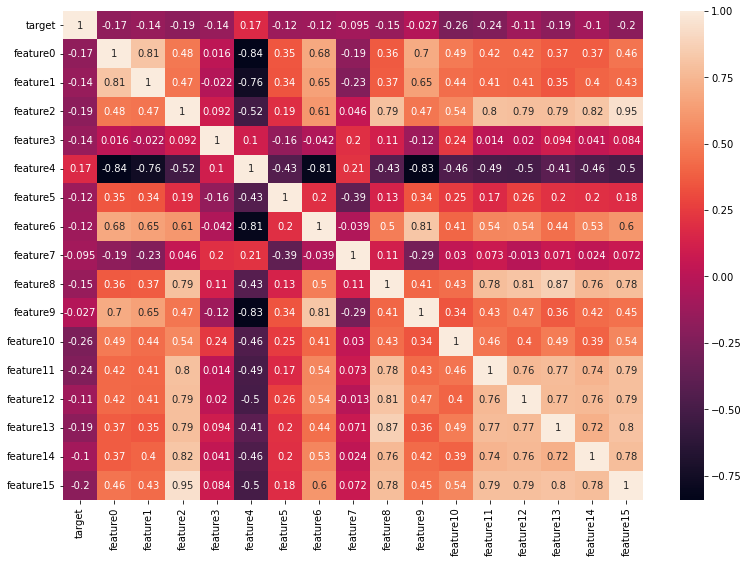

In [20]:
#spearman
df_corr = df_transformed[['target', 'feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
                          'feature6', 'feature7', 'feature8', 'feature9', 'feature10',
                          'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].corr(method='spearman')

plt.figure(figsize=(13, 9))
sns.heatmap(df_corr, annot=True)

O limiar que eu defini foi de 0.12 positivo ou negativo, portanto todos os atributos que tiverem mais de 0.12 de correlação será considerado no modelo.

In [21]:
X = df_transformed.copy()
Y = X['target']

threshold_corr = 0.12
colunas_drop = ['target']
colunas_drop.extend(list(df_corr.loc[np.abs(df_corr['target']) < threshold_corr, 'target'].index))

X.drop(columns=colunas_drop, inplace=True)

X_val = X.values

print(f'Colunas Drop: {colunas_drop}')

Colunas Drop: ['target', 'feature6', 'feature7', 'feature9', 'feature12', 'feature14']


<h2>DIVISÃO EM TREINO E TESTE</h2>

Agora irei dividir os dados em treinamento e teste utilizando o método padrão para isso o `train_test_split`. Vou utilizar a divisão comum em Machine Learning, 70% dos dados para treinamento e 30% para testes.

In [22]:
#Separando os dados em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X_val, Y, test_size = 0.3, random_state = 100)

<h2>ESCALA DOS DADOS</h2>

Uma etapa muito importante em Machine Learning, é a escala dos dados. Nesse primeiro momento estarei escolhendo o método RobustEscaler para testar a primeira versão do modelo.<br/>
Escolhi este método porque eu quero reduzir o impacto que os outliers tem sobre o modelo.

In [23]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

display(pd.DataFrame(scaler.transform(X_val)).describe())
display(pd.DataFrame(scaler.transform(X_val)).skew())

,0,1,2,3,4,5,6,7,8,9,10
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,0.206272,0.253780,0.585905,0.055837,-0.317890,0.153889,0.230667,0.267625,0.319010,0.214129,0.470122
std,0.677101,1.155104,1.293893,0.652079,0.785940,0.700716,0.682119,0.634059,0.805090,0.648871,1.074210
min,-0.500000,-1.000000,-0.332287,-1.878882,-2.353943,-0.569877,-0.384224,-0.420308,-0.332677,-0.365484,-0.333333
25%,-0.333333,-0.500000,-0.332287,-0.447739,-0.692467,-0.481530,-0.384224,-0.270828,-0.332677,-0.365484,-0.333333
50%,0.000000,0.000000,0.036787,-0.101792,-0.037591,0.000000,-0.040882,-0.003844,-0.046901,-0.007785,0.000000
75%,0.666667,0.500000,0.733749,0.470753,0.315787,0.496862,0.616472,0.738504,0.667323,0.592287,0.666667
max,2.166667,3.500000,4.172413,2.027587,0.516866,2.227293,2.342158,2.140613,2.729069,2.245414,3.333333


0     0.982685
1     1.281436
2     1.706012
3     0.421603
4    -1.040210
5     1.005006
6     1.007111
7     0.886886
8     1.219605
9     1.074667
10    1.680437
dtype: float64

<h2>MODELAGEM BASE</h2>

Essa é a primeira versão do modelo, portanto, eu escolhi alguns algoritmos padrões para realizar uma primeira avaliação.
* **KNN**: Porque é um dos algoritmos mais básicos quando se trata de Machine Learning;
* **Logistic Regression**: Um algoritmo linear para confirmar a hipótese de que algoritmos lineares não funcionam para esse problema;
* **Random Forest e XGBoost**: Provavelmente os algoritmos que terão melhores resultados, os algoritmos não lineares baseados em árvores;
* **SVM**: Vamos aumentar a dimensão do problema para testar se ele consegue se tornar linearmente separável com as SVMs;

Como métricas de avaliação irei utilizar duas:
* **Acurácia**: A mais básica de todas e também mais simples. Simplesmente a média aritmética de quantos casos o modelo acertou. Estarei utilizando esta pelo fato de que o conjunto está bem balanceado;
* **F1 Score**: A média harmônica entre o Precision e o Recall. Vou utilizar o F1 Score porque eu não tenho um contexto sobre os dados, portanto não tem sentido utilizar as métricas Precision ou Recall.

**K Fold**

In [24]:
k_fold = KFold(n_splits=20, shuffle=True, random_state=0)

**KNN**

O KNN é um dos algoritmos mais simples para Machine Learning, sendo um algoritmo do tipo "lazy", ou seja, nenhuma computação é realizada no dataset até que um novo ponto de dado seja alvo de teste.

Ele é um algoritmo não-linear que utiliza uma métrica de distância para encontrar o valor de K mais adequado as instâncias do dataset de treino.

In [25]:
#Criando o modelo KNN
KNN = KNeighborsClassifier(n_neighbors = 8, p=1)

#Utilizando o Cross Validation
scoring = 'f1'
score = cross_val_score(KNN, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print('\nScore no conjunto de treino com cross_val_score: {}%'.format(round(np.mean(score) * 100, 2)))

KNN = KNN.fit(X_train, Y_train)
preds = KNN.predict(X_test)
print('Acurácia no conjunto de testes: {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

[0.76190476 0.875      0.69565217 0.63636364 0.53333333 0.6
 0.5        0.5        0.57142857 0.66666667 0.53333333 0.76190476
 0.82352941 0.81818182 0.8        0.70588235 0.35294118 0.77777778
 0.54545455 0.33333333]

Score no conjunto de treino com cross_val_score: 63.96%
Acurácia no conjunto de testes: 72.66%
F1 Score no conjunto de testes: 74.32%
Precision no conjunto de testes: 78.57%
Recall no conjunto de testes: 70.51%


**Logistic Regression**

A regressão logística é um algoritmo de aprendizagem de máquina supervisionado utilizado para classificação, apesar de ter a palavra regressão em seu nome.
Esta consiste em analisar cada classe de forma separada contra todas as outras, criando um classificador para cada possibilidade, dessa forma se calcula a probabilidade de uma dada instância pertencer a classe em questão ou não. Ao final, a classe selecionada será aquela que apresentar a maior probabilidade.

In [26]:
logisticReg = LogisticRegression()
logisticReg.fit(X_train, Y_train)

preds = logisticReg.predict(X_test)
f_score = f1_score(preds, Y_test)
ac_score = accuracy_score(preds, Y_test)

print('F1 score em Teste = {:.2f}%'.format(f_score * 100))
print('Acurácia em Teste = {:.2f}%'.format(ac_score * 100))

F1 score em Teste = 71.08%
Acurácia em Teste = 65.47%
Precision no conjunto de testes: 67.05%
Recall no conjunto de testes: 75.64%


**Random Forest**

Modelos compostos por múltiplos modelos mais fracos que são independentemente treinados e a previsão combina esse modelos de alguma forma; Criam vários modelos de árvores diferentes, selecionando diferentes atributos com diferentes configurações. A partir daí o melhor modelo será selecionado através de um processo de votação.

In [27]:
#Criando o modelo randomForest
randomForest = RandomForestClassifier()

#Utilizando o Cross Validation
scoring = 'f1'
score = cross_val_score(randomForest, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print('\nScore no conjunto de treino com cross_val_score: {}%'.format(round(np.mean(score) * 100, 2)))

randomForest = randomForest.fit(X_train, Y_train)
preds = randomForest.predict(X_test)
print('Acurácia no conjunto de testes: {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

[0.91666667 0.70588235 0.83333333 0.7826087  0.70588235 0.8
 0.61538462 0.625      0.53333333 0.66666667 0.88888889 0.81818182
 0.73684211 0.90909091 0.9        0.8        0.72727273 0.85714286
 0.76923077 0.71428571]

Score no conjunto de treino com cross_val_score: 76.53%
Acurácia no conjunto de testes: 80.58%
F1 Score no conjunto de testes: 82.35%
Precision no conjunto de testes: 84.0%
Recall no conjunto de testes: 80.77%


**SVM Classifier**

O algoritmo Support Vector Machine traça uma reta e tenta separar linearmente e classificar o conjunto de dados. O algoritmo tenta encontrar a reta que tenha maior distância dentre as classes prevista.

Para aplicar o SVC em conjuntos de dados não linearmente separáveis é necessário configurar o parâmetro Kernel. Este parâmetro é responsável por traçar não somente retas, mas também outros tipos de linhas no conjunto de dados.

In [28]:
#Criando o modelo svc
svc = SVC()

#Utilizando o Cross Validation
scoring = 'f1'
score = cross_val_score(svc, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print('\nScore no conjunto de treino com cross_val_score: {}%'.format(round(np.mean(score) * 100, 2)))

svc = svc.fit(X_train, Y_train)
preds = svc.predict(X_test)
print('Acurácia no conjunto de testes: {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

[0.88       0.7        0.81481481 0.69565217 0.6        0.66666667
 0.46153846 0.625      0.70588235 0.70588235 0.7        0.7826087
 0.77777778 0.86956522 0.90909091 0.73684211 0.72727273 0.81818182
 0.53333333 0.5       ]

Score no conjunto de treino com cross_val_score: 71.05%
Acurácia no conjunto de testes: 70.5%
F1 Score no conjunto de testes: 76.02%
Precision no conjunto de testes: 69.89%
Recall no conjunto de testes: 83.33%


**XGB Classifier**

O gradient boosting é uma técnica de aprendizado de máquina para problemas de regressão e classificação, que produz um modelo de previsão na forma de um ensemble de modelos de previsão fracos, geralmente árvores de decisão . Ela constrói o modelo em etapas, como outros métodos de boosting, e os generaliza, permitindo a otimização de uma função de perda diferenciável arbitrária.

In [29]:
#Criando o modelo XGBClassifier
xgb = XGBClassifier(max_depth=3, eta=0.3, scale_pos_weight=2, n_estimators=200)

#Utilizando o Cross Validation
scoring = 'f1'
score = cross_val_score(xgb, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print('\nScore no conjunto de treino com cross_val_score: {}%'.format(round(np.mean(score) * 100, 2)))

xgb = xgb.fit(X_train, Y_train)
preds = xgb.predict(X_test)
print('Acurácia no conjunto de testes: {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

print('Precision no conjunto de testes: {}%'.format(round(precision_score(Y_test, preds) * 100, 2)))
print('Recall no conjunto de testes: {}%'.format(round(recall_score(Y_test, preds) * 100, 2)))

[0.81818182 0.70588235 0.72727273 0.75       0.77777778 0.88
 0.61538462 0.8        0.85714286 0.82352941 0.84210526 0.86956522
 0.84210526 0.8        0.9        0.82352941 0.75       0.85714286
 0.61538462 0.66666667]

Score no conjunto de treino com cross_val_score: 78.61%
Acurácia no conjunto de testes: 78.42%
F1 Score no conjunto de testes: 81.25%
Precision no conjunto de testes: 79.27%
Recall no conjunto de testes: 83.33%


---

<h2>MODELAGEM AUTOMATIZADA</h2>

Depois de ter feito uma primeira modelagem e obtido alguns resultados, irei criar um modelagem mais automatizada com o intuito de testar diferentes parâmetros para os algoritmos que serão selecionados para o modelo.
* Primeiro eu irei criar uma lista passando os seguintes dados:
    * Nome do algoritmo;
    * Instância do objeto;
    * Grid de parâmetros que serão testados;

* Irei criar uma função que recebe essa lista e testa todos os algoritmos com diferentes possibilidades de métodos de escala dos dados;

Com isso, poderei testar várias possibilidades a fim de obter o melhor modelo com a melhor escala e os melhores parâmetros.

In [33]:
list_estimators = [
   {'name': 'SVM - Support Vector Machine',
     'model': SVC(),
     'params': {}
    },

    {'name': 'Random Forest',
     'model': RandomForestClassifier(),
     'params': {
            'n_estimators': [100],
            'bootstrap': [True, False], 
            'criterion': ['entropy'], 
            'min_samples_leaf': [1, 5, 10], 
            'min_samples_split': [10, 20, 30]
     }
    },

    {
       'name': 'XGB - Extreme Boosting Classifier',
       'model': XGBClassifier(),
       'params': {
          'eta': [0.3],
          'max_depth': [3],
          'gamma': [0, 1],
          'scale_pos_weight': [0, 2]
          #'alpha': [0.5, 1, 1.5],
          #'lambda': [0.5, 1, 1.5]
       }
    }
    
    ]

**Matriz de confusão**

Abaixo estou criando uma função para exibir de maneira visual a matriz de confusão do nosso modelo. A matriz de confusão serve para analisarmos todos os valores verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos previstos pelo modelo.

In [34]:
x_axes = ['Não [0]', 'Sim [1]']
y_axes =  ['Sim [1]', 'Não [0]']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='ice')

    # add title
    fig.update_layout(
        title_text='<span><b>Confusion matrix</b></span>',
        xaxis = dict(title='Valores previstos'),
        yaxis = dict(title='Valores reais'),
        width=300,
        height=300
        )

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()
    #return fig

<h3>Função Auto Modelo</h3>

In [35]:
def autoModel(X_train, Y_train, X_test, Y_test):

    #Inicializando variáveis
    list_all_results = []
    list_standardization = [Normalizer(), StandardScaler(), RobustScaler(), PowerTransformer(), MinMaxScaler()]

    best_acc = 0
    best_model = {
        'name': 'null',
        'model_grid': 'null',
        'best_params': 'null',
        'stand': 'null',
        'acc_train': 0,
        'acc_test': 0
    }

    #Para cada tipo de padronização iteramos
    for stand in list_standardization:

        #Para cada algoritmo na lista de algoritmos
        for estimator in list_estimators:
            
            #Criação do objeto GridSearch
            model_grid = GridSearchCV(estimator=estimator['model'], param_grid=estimator['params'], cv=10)
            
            #Criação do pipeline de execução
            pipe = Pipeline(steps=[('scale', stand), ('grid', model_grid)])
            pipe.fit(X_train, Y_train)

            #Realizando as previsões para cada dataset. Treino e teste
            preds_train = pipe.predict(X_train)
            preds_test = pipe.predict(X_test)
            
            #Otendo os resultados para cada métrica
            acc_train = accuracy_score(preds_train, Y_train)
            acc_test = accuracy_score(preds_test, Y_test)
            f1_train = f1_score(preds_train, Y_train)
            f1_test = f1_score(preds_test, Y_test)

            #Exibindo os resultados por acurácia, f1 score e matriz de confusão de treino e teste para cada algoritmo.
            print('Algoritmo: [{}]'.format(estimator['name'])) 
            print('stand:[{}] [ACCURACY] train:[{}%]  test:[{}%]'.format(stand, round(acc_train * 100, 2), round(acc_test * 100, 2)))
            print('stand:[{}] [F1 SCORE] train:[{}%]  test:[{}%]'.format(stand, round(f1_train * 100, 2), round(f1_test * 100, 2)))
            conf_matrix(confusion_matrix(preds_test, Y_test))

            #Armazenando sempre o melhor resultado
            if acc_test > best_model['acc_test']:
                best_model['name'] = estimator['name'],
                best_model['model_grid'] = pipe['grid'].estimator,
                best_model['best_params'] =  pipe[1].best_params_,
                best_model['stand'] = stand
                best_model['acc_train'] = acc_train
                best_model['acc_test'] = acc_test

            #Armazenando todos os resultados em uma lista para exibir em um dataframe final
            list_all_results.append(
                {'name': estimator['name'],
                'standardization': re.sub(r'[()]', '', str(stand)),
                'f1 score': round(f1_test * 100, 2)
                })

    return best_model, list_all_results

In [36]:
#Treinando, testando e avaliando os algoritmos
X_train, X_test, Y_train, Y_test = train_test_split(X_val, Y, test_size = 0.3, random_state = 100)

best_model, list_all_results = autoModel(X_train, Y_train, X_test, Y_test)

Algoritmo: [SVM - Support Vector Machine]
stand:[Normalizer()] [ACCURACY] train:[56.17%]  test:[56.12%]
stand:[Normalizer()] [F1 SCORE] train:[70.78%]  test:[70.53%]


Algoritmo: [Random Forest]
stand:[Normalizer()] [ACCURACY] train:[91.05%]  test:[66.19%]
stand:[Normalizer()] [F1 SCORE] train:[92.39%]  test:[72.19%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[Normalizer()] [ACCURACY] train:[94.14%]  test:[64.75%]
stand:[Normalizer()] [F1 SCORE] train:[95.01%]  test:[71.01%]


Algoritmo: [SVM - Support Vector Machine]
stand:[StandardScaler()] [ACCURACY] train:[75.31%]  test:[71.94%]
stand:[StandardScaler()] [F1 SCORE] train:[80.3%]  test:[76.92%]


Algoritmo: [Random Forest]
stand:[StandardScaler()] [ACCURACY] train:[93.52%]  test:[79.86%]
stand:[StandardScaler()] [F1 SCORE] train:[94.34%]  test:[82.72%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[StandardScaler()] [ACCURACY] train:[100.0%]  test:[80.58%]
stand:[StandardScaler()] [F1 SCORE] train:[100.0%]  test:[83.44%]


Algoritmo: [SVM - Support Vector Machine]
stand:[RobustScaler()] [ACCURACY] train:[74.38%]  test:[70.5%]
stand:[RobustScaler()] [F1 SCORE] train:[79.71%]  test:[76.02%]


Algoritmo: [Random Forest]
stand:[RobustScaler()] [ACCURACY] train:[98.15%]  test:[79.14%]
stand:[RobustScaler()] [F1 SCORE] train:[98.36%]  test:[82.42%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[RobustScaler()] [ACCURACY] train:[100.0%]  test:[80.58%]
stand:[RobustScaler()] [F1 SCORE] train:[100.0%]  test:[83.44%]


Algoritmo: [SVM - Support Vector Machine]
stand:[PowerTransformer()] [ACCURACY] train:[73.15%]  test:[67.63%]
stand:[PowerTransformer()] [F1 SCORE] train:[77.86%]  test:[73.05%]


Algoritmo: [Random Forest]
stand:[PowerTransformer()] [ACCURACY] train:[96.6%]  test:[78.42%]
stand:[PowerTransformer()] [F1 SCORE] train:[97.05%]  test:[81.25%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[PowerTransformer()] [ACCURACY] train:[100.0%]  test:[80.58%]
stand:[PowerTransformer()] [F1 SCORE] train:[100.0%]  test:[83.44%]


Algoritmo: [SVM - Support Vector Machine]
stand:[MinMaxScaler()] [ACCURACY] train:[72.22%]  test:[69.78%]
stand:[MinMaxScaler()] [F1 SCORE] train:[77.72%]  test:[75.29%]


Algoritmo: [Random Forest]
stand:[MinMaxScaler()] [ACCURACY] train:[100.0%]  test:[78.42%]
stand:[MinMaxScaler()] [F1 SCORE] train:[100.0%]  test:[80.77%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[MinMaxScaler()] [ACCURACY] train:[100.0%]  test:[80.58%]
stand:[MinMaxScaler()] [F1 SCORE] train:[100.0%]  test:[83.44%]


<h3>Avaliando os resultados</h3>

In [37]:
df_results = pd.DataFrame(list_all_results)
df_results = df_results.sort_values(by='f1 score', ascending=False)
display(df_results)

,name,standardization,f1 score
5,XGB - Extreme Boosting Classifier,StandardScaler,83.44
8,XGB - Extreme Boosting Classifier,RobustScaler,83.44
11,XGB - Extreme Boosting Classifier,PowerTransformer,83.44
14,XGB - Extreme Boosting Classifier,MinMaxScaler,83.44
4,Random Forest,StandardScaler,82.72
7,Random Forest,RobustScaler,82.42
10,Random Forest,PowerTransformer,81.25
13,Random Forest,MinMaxScaler,80.77
3,SVM - Support Vector Machine,StandardScaler,76.92
6,SVM - Support Vector Machine,RobustScaler,76.02


In [38]:
#Exportando a lista de resultados para uma análise posterior.
df_results.to_excel('resultados_algoritmos.xlsx', index=False)

<h2>EXPORTANDO O MODELO</h2>

Agora que temos o melhor modelo, eu irei exportar o pipeline contendo o método de escala, o grid com os melhores parâmetros e o modelo em si.

In [39]:
#Selecionando o melhor algoritmo e seus melhores parâmetros
estimator = best_model['model_grid'][0]
params = best_model['best_params'][0].copy()

#Seleção da melhor padronização
stand = best_model['stand']

#Convertendo para o formato que o GridSearch aceita. Formato de lista.
for key in params:
    lst = [params[key]]
    params[key] = lst

    
#Criação do modelo GridSearch final
final_model = GridSearchCV(estimator=estimator, param_grid=params, cv=10)

#Criação do pipeline de execução
pipe = Pipeline(steps=[('scale', stand), ('grid', final_model)])

In [40]:
#Treinamento do modelo final
pipe.fit(X_val, Y)
preds = pipe.predict(X_val)

#Avaliando o resultado final
f1_test = f1_score(preds, Y)
print('O F1 SCORE do modelo final foi de: {}%'.format(round(f1_test * 100, 2)))

O F1 SCORE do modelo final foi de: 99.04%


**Exportando**

In [41]:
import joblib
import time

In [42]:
timestr = time.strftime("%Y%m%d-%H%M%S")

# Salva o modelo em disco
joblib.dump(pipe, f'modelo/modelo-{timestr}.pkl')

['modelo/modelo-20220801-095132.pkl']

<h2>CONSIDERAÇÕES SOBRE OS RESULTADOS OBTIDOS</h2>

O algoritmo que obteve maior eficiência foi o XGB - Extreme Boosting Classifier com o score final no conjunto de testes de 83%. É difícil mensurar se esse score é bom ou ruim, uma vez que não tenho contexto sobre os dados.

Mas, dado que os dados praticamente não tinham correlação com o atributo target, acredito que um score "baixo" era esperado.

Eu apliquei várias técnicas para identificar os outliers, mas basicamente preenchi os dados com suas medianas agrupadas por target ou clusters. Talvez aplicar outra técnica para preencher os dados outliers fosse tornar mais eficaz o modelo. 

O modelo foi exportado para o diretório `notebook/modelo` deste projeto. E vai poder ser testado pela aplicação Flask que eu desenvolvi.

---

Atenciosamente,


Henrique Krupck.

# Fim